# Explore the MHW Systems a bit

In [43]:
%matplotlib notebook

In [204]:
# imports
import numpy as np
import os
from scipy.interpolate import interp1d

from datetime import date

from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature 
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import pandas as pd
import iris
import iris.quickplot as qplt

import healpy as hp

from oceanpy.sst import io as sst_io

# Load

In [2]:
path = '/home/xavier/Projects/Oceanography/MHW/db'

In [4]:
sys_file = os.path.join(path, 'MHW_systems_2000.npz')

In [9]:
mhw_sys_npz = np.load(sys_file)

In [10]:
mhw_sys_npz.files

['Id',
 'NSpax',
 'xcen',
 'xboxmin',
 'xboxmax',
 'ycen',
 'yboxmin',
 'yboxmax',
 'zcen',
 'zboxmin',
 'zboxmax']

In [23]:
mhw_sys_npz['Id']

array([    1,     2,     3, ..., 99354, 99355, 99356], dtype=int32)

# Table

In [24]:
tmp = pd.Series(mhw_sys_npz['Id'])
tmp

0            1
1            2
2            3
3            4
4            5
         ...  
99351    99352
99352    99353
99353    99354
99354    99355
99355    99356
Length: 99356, dtype: int32

In [25]:
tmp2= pd.DataFrame()
tmp2['Id'] = tmp
tmp2

,Id
0,1
1,2
2,3
3,4
4,5
...,...
99351,99352
99352,99353
99353,99354
99354,99355


In [26]:
mhw_sys = pd.DataFrame()
series = []
for key in mhw_sys_npz.keys():
    s = pd.Series(mhw_sys_npz[key])
    mhw_sys[key] = s

In [27]:
mhw_sys

,Id,NSpax,xcen,xboxmin,xboxmax,ycen,yboxmin,yboxmax,zcen,zboxmin,zboxmax
0,1,1068,46.225655,46,50,671.013123,663,681,100.861420,68,132
1,2,15708,55.034248,46,72,685.501404,650,740,230.010315,156,329
2,3,34,45.500000,46,46,663.588257,663,666,365.970581,362,373
3,4,5387,52.332745,46,71,674.276123,651,706,472.054840,432,500
4,5,24,45.500000,46,46,664.000000,663,666,571.000000,569,574
...,...,...,...,...,...,...,...,...,...,...,...
99351,99352,5,715.500000,716,716,1437.500000,1438,1438,702.500000,701,705
99352,99353,35,716.500000,717,717,22.500000,20,26,1894.500000,1893,1897
99353,99354,205,717.134155,717,718,1423.353638,1413,1438,703.500000,702,706
99354,99355,60,717.500000,718,718,6.000000,1,12,1896.500000,1895,1899


# Histograms

## $N_{spax}$

In [31]:
mhw_sys['logN'] = np.log10(mhw_sys['NSpax'])

<IPython.core.display.Javascript object>


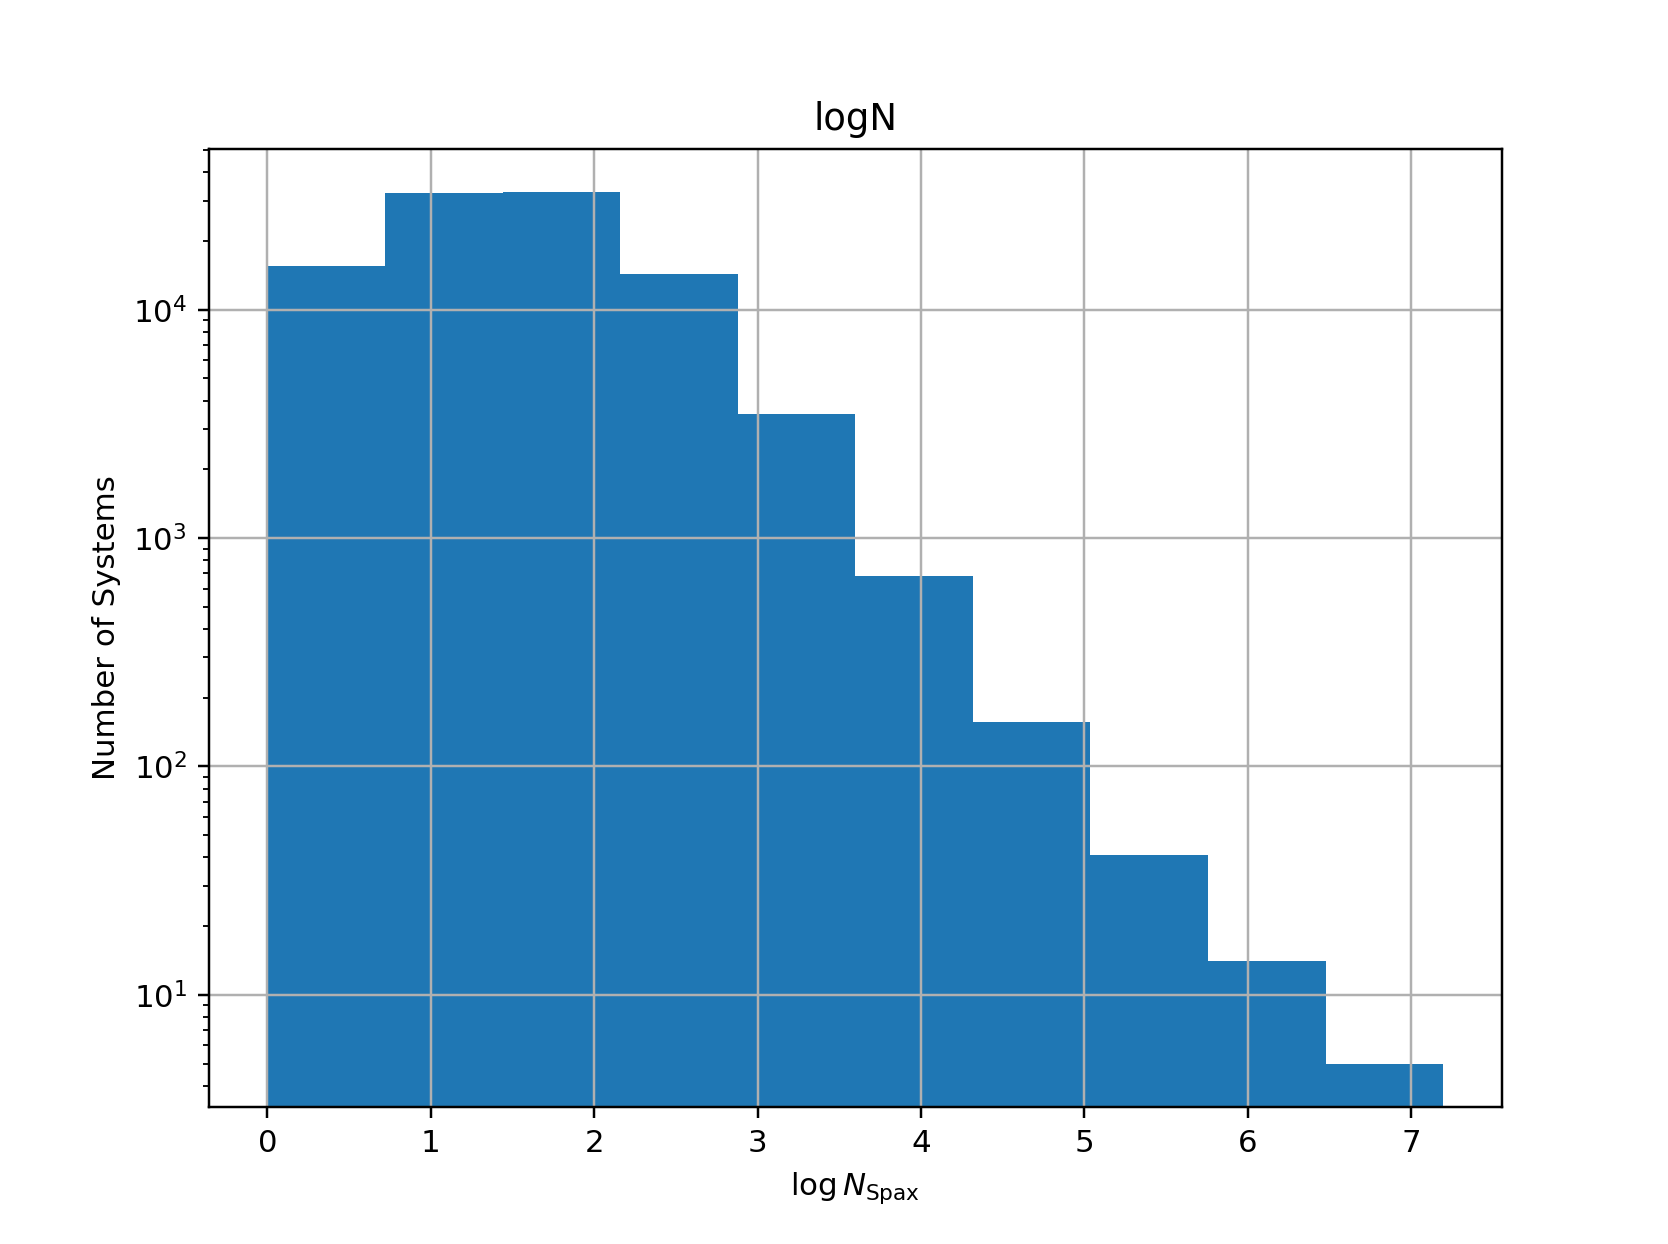

In [186]:
plt.clf()
ax = plt.gca()
mhw_sys.hist(column='logN', ax=ax)
#
ax.set_xlabel(r'$\log \, N_{\rm Spax}$')
ax.set_ylabel(r'Number of Systems')
ax.set_yscale('log')
#
plt.show()

## Extreme

In [36]:
extreme = mhw_sys['NSpax'].values > 1e4
np.sum(extreme)

380

<IPython.core.display.Javascript object>


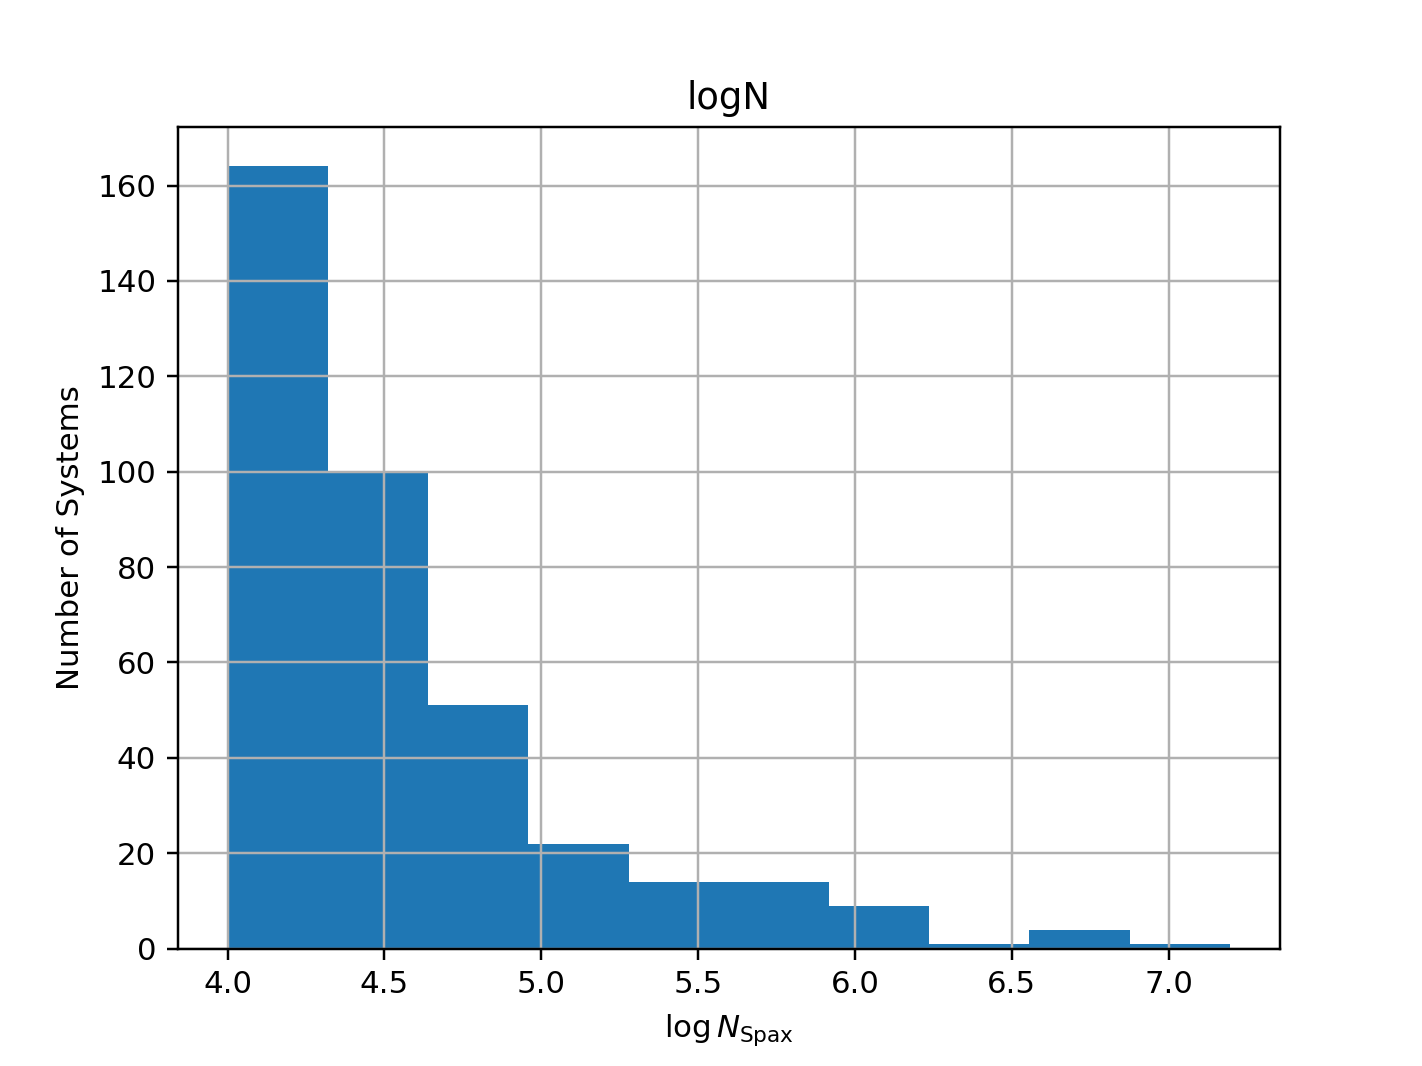

In [187]:
plt.clf()
ax = plt.gca()
mhw_sys[extreme].hist(column='logN', ax=ax)
#
ax.set_xlabel(r'$\log \, N_{\rm Spax}$')
ax.set_ylabel(r'Number of Systems')
#
plt.show()

### Durations

In [41]:
mhw_sys['logDt'] = np.log10(mhw_sys['zboxmax'] - mhw_sys['zboxmin'])

/home/xavier/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [212]:
np.min(mhw_sys['logDt'])

-inf

<IPython.core.display.Javascript object>


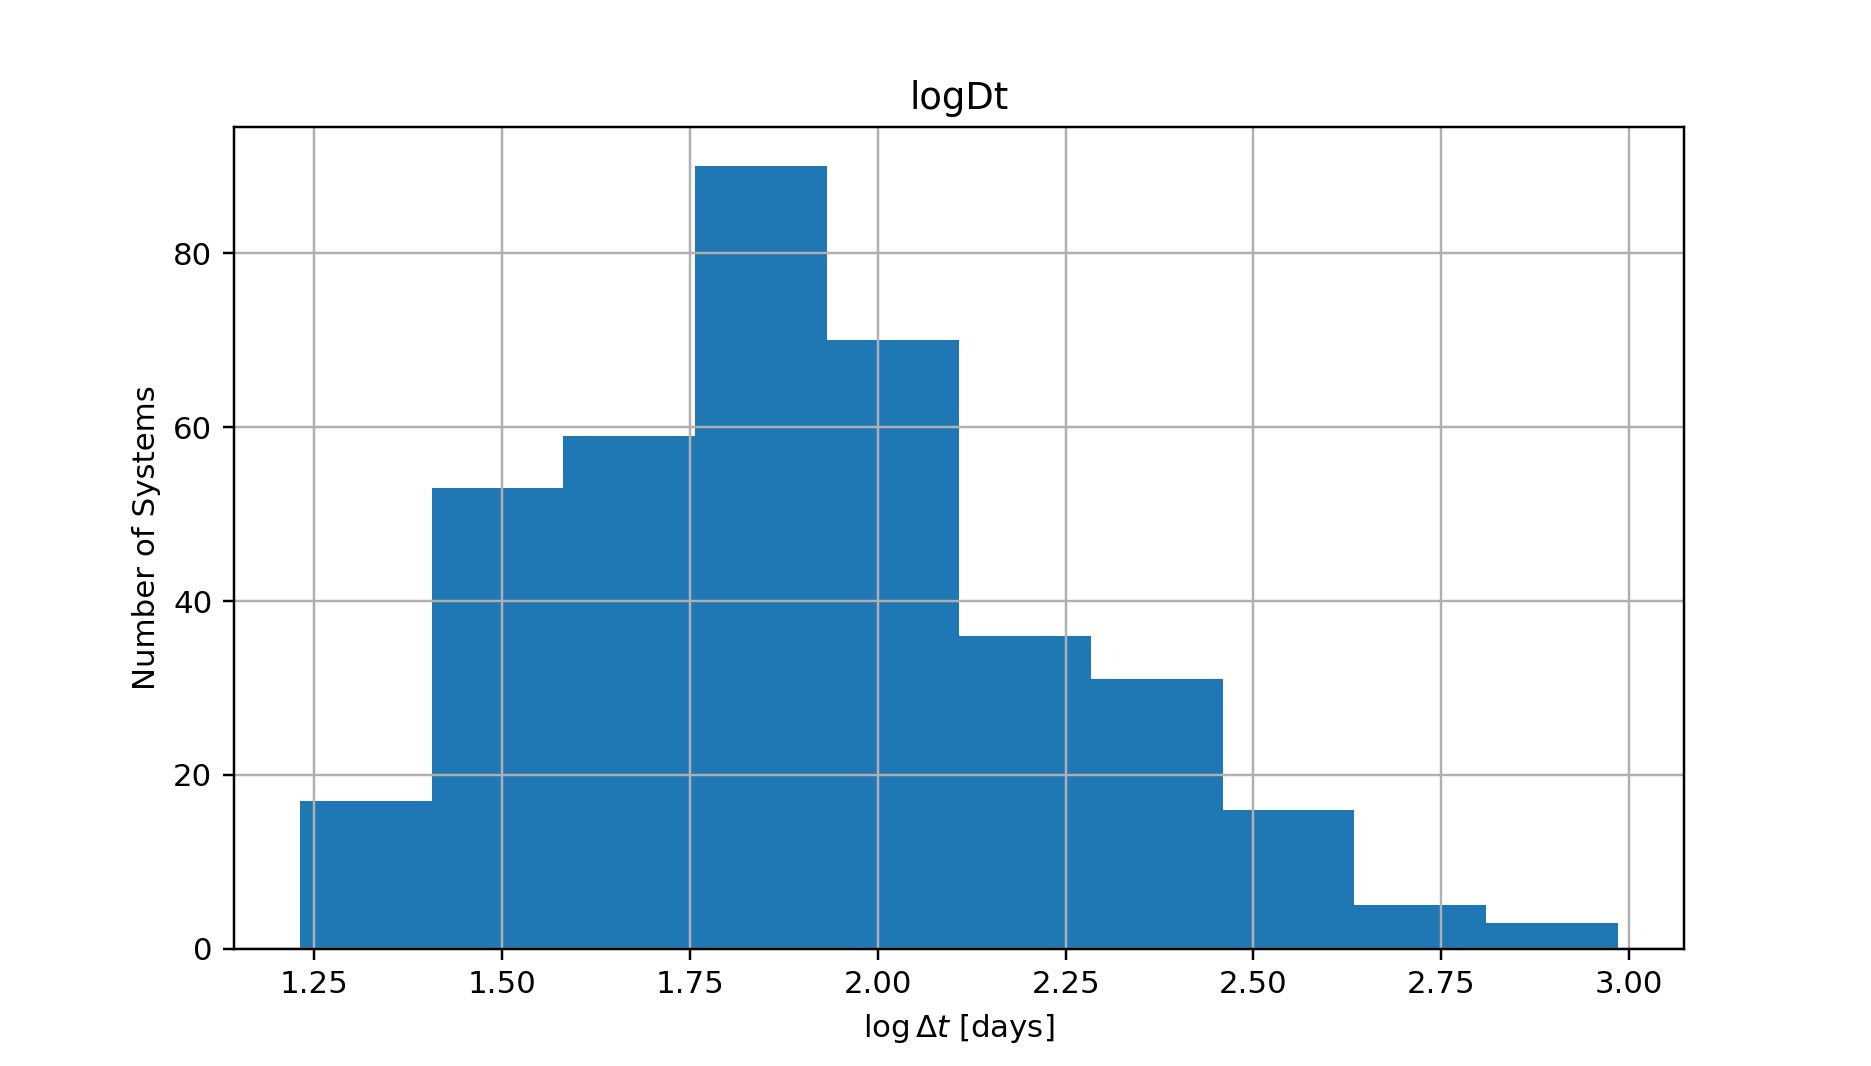

In [210]:
plt.clf()
ax = plt.gca()
mhw_sys[extreme].hist(column='logDt', ax=ax)
#
ax.set_xlabel(r'$\log \, \Delta t$ [days]')
ax.set_ylabel(r'Number of Systems')
#
plt.show()

# Most extreme

In [188]:
i_maxN = np.argmax(mhw_sys['NSpax'])

In [195]:
mhw_sys.iloc[i_maxN]

Id         1.614000e+03
NSpax      1.568217e+07
xcen       2.796365e+02
xboxmin    6.200000e+01
xboxmax    6.030000e+02
ycen       9.964585e+02
yboxmin    4.980000e+02
yboxmax    1.438000e+03
zcen       4.371489e+02
zboxmin    1.000000e+00
zboxmax    9.680000e+02
logN       7.195406e+00
Dt         9.670000e+02
logDt      2.985426e+00
Name: 1613, dtype: float64

In [202]:
lat_max, lon_max = float(f_lat(mhw_sys.iloc[i_maxN]['xcen'])), float(f_lon(mhw_sys.iloc[i_maxN]['ycen']))

In [203]:
lat_max, lon_max

(-19.96588134765625, 249.2396240234375)

In [209]:
date_max = date.fromordinal(723546 + int(mhw_sys.iloc[i_maxN]['zcen']))
date_max

datetime.date(1983, 3, 14)

# Maps

In [139]:
# For healpix
nside = 64

## Grab an NOAA SST for convenience

In [57]:
noaa = sst_io.load_noaa((1,1,2003))

In [58]:
noaa

<iris 'Cube' of Daily Sea Surface Temperature / (degC) (latitude: 720; longitude: 1440)>

In [78]:
lat_coord = noaa.coord('latitude')
lon_coord = noaa.coord('longitude')

In [103]:
f_lat = interp1d(np.arange(lat_coord.points.size), lat_coord.points)
f_lon = interp1d(np.arange(lon_coord.points.size), lon_coord.points)

In [168]:
noaa_hp = sst_io.load_noaa((1,1,2003), nside=nside, mask=True)

## Sum em up

In [71]:
ilat = np.minimum(mhw_sys['xcen'].values.astype(int), 719)
jlon = mhw_sys['ycen'].values.astype(int)

In [69]:
ilat

array([ 46,  55,  45, ..., 717, 717, 717])

In [72]:
np.max(jlon)

1437

In [85]:
n_events  = np.zeros((lat_coord.points.shape[0], lon_coord.points.shape[0]))
for ii, jj in zip(ilat, jlon):
    n_events[ii,jj] += 1

In [86]:
np.max(n_events)

16.0

## Events on a mollweide

## Prep

In [141]:
npix_hp = hp.nside2npix(nside)

### Coords

In [106]:
lats = f_lat(np.minimum(mhw_sys['xcen'].values, 719.))
lats

array([-78.31858635, -76.11643791, -78.5       , ...,  89.40853882,
        89.5       ,  89.5       ])

In [107]:
lons = f_lon(mhw_sys['ycen'].values)
lons

array([167.87828064, 171.50035095, 166.02206421, ..., 355.96340942,
         1.625     ,  40.625     ])

## All

In [142]:
theta = (90 - lats)*np.pi/180.
phi = lons*np.pi/180.
idx_all = hp.pixelfunc.ang2pix(nside, theta, phi)

In [143]:
all_events = np.ma.masked_array(np.zeros(npix_hp, dtype='int'))
for idx in idx_all:
    all_events[idx] += 1

In [176]:
# mask
all_events.mask = noaa_hp.mask
all_events[all_events.mask] = -1
all_events = hp.ma(all_events.astype(float))

### Plot

<IPython.core.display.Javascript object>


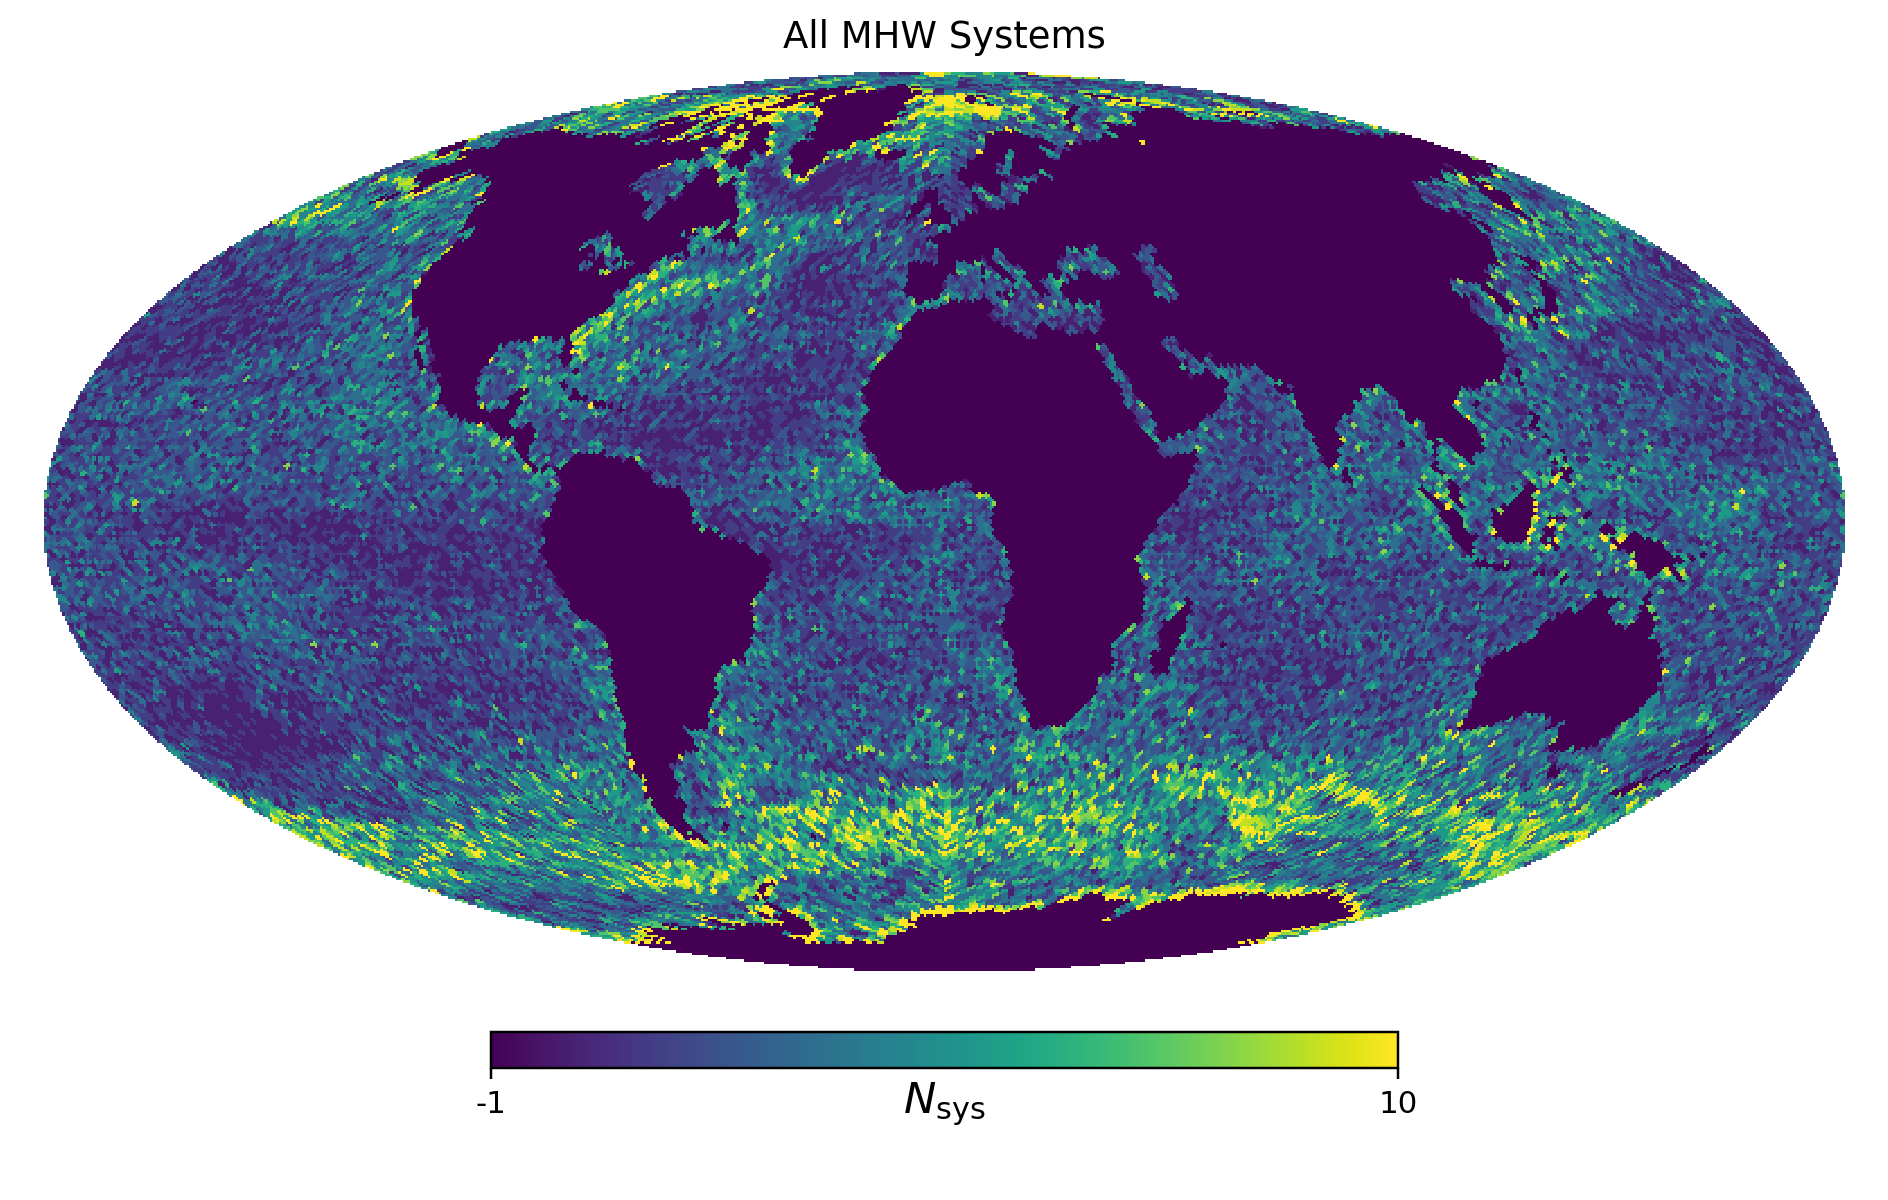

In [179]:
hp.mollview(all_events, min=-1, max=10, flip='geo', title='All MHW Systems', unit=r'$N_{\rm sys}$')

## Extreme

In [162]:
ex_events = np.ma.masked_array(np.zeros(npix_hp, dtype='int'))
for idx in idx_all[extreme]:
    ex_events[idx] += 1

In [172]:
# mask
ex_events.mask = noaa_hp.mask
ex_events[ex_events.mask] = -1
ex_events = hp.ma(ex_events.astype(float))

In [173]:
noaa_hp.mask

array([False, False, False, ...,  True,  True,  True])

<IPython.core.display.Javascript object>


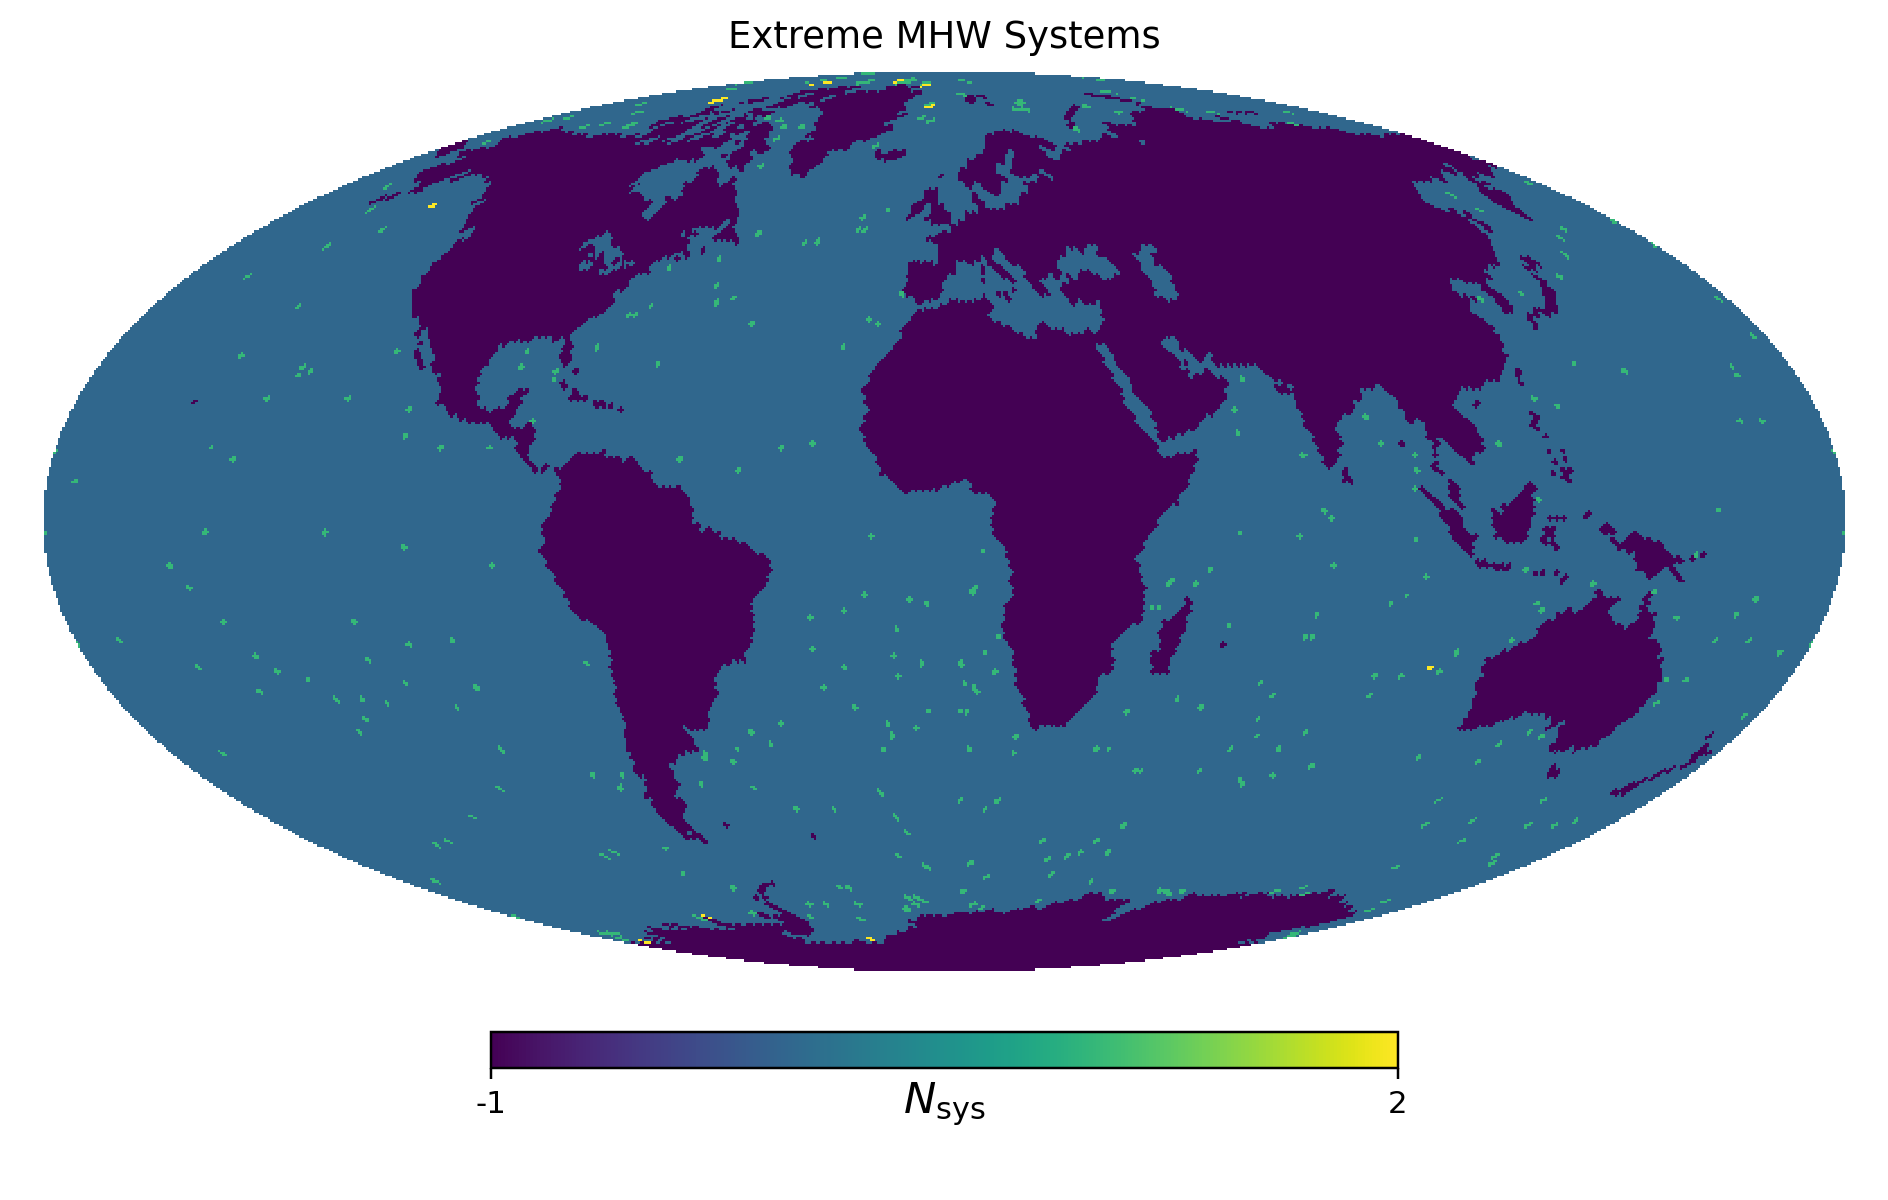

In [174]:
hp.mollview(ex_events, flip='geo', title='Extreme MHW Systems', unit=r'$N_{\rm sys}$', min=-1, max=2)

----

In [109]:
theta, phi = np.degrees(hp.pix2ang(nside=nside, ipix=np.arange(npix_hp)))

In [110]:
theta

array([  0.3654835,   0.3654835,   0.3654835, ..., 179.6345165,
       179.6345165, 179.6345165])